In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [3]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/rebalanced/rus.csv"
df = pd.read_csv(dataset_path)

del df['Hour']
del df['Date']

df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,16.081972,8.690398,7.360829,5.627949,10.859625,1
2,2,2,0,1,16.064222,8.711492,6.798350,5.695267,10.875454,1
3,2,2,0,1,15.726965,9.281037,6.458978,6.770428,11.357474,1
4,2,2,0,1,15.608629,9.414634,6.998203,6.968535,11.452773,1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,16.081972,8.690398,7.360829,5.627949,10.859625,1
2,2,2,0,1,16.064222,8.711492,6.798350,5.695267,10.875454,1
3,2,2,0,1,15.726965,9.281037,6.458978,6.770428,11.357474,1
4,2,2,0,1,15.608629,9.414634,6.998203,6.968535,11.452773,1


# Data Partitioning

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [0]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear *Regression* 

Coefficients: 
 [0.90959955]
   
R2: 0.867887
Mean squared error: 1.371061
Mean Absolute error:
0.9631590539895963


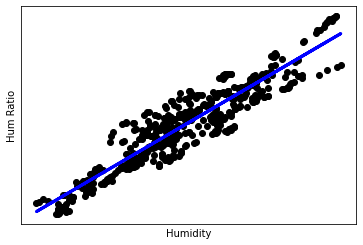

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model

Hum = df['Humidity'].values
Hum_R = df['HumidityRatio'].values

Hum_X_train, Hum_X_test, Hum_y_train, Hum_y_test = train_test_split(Hum, Hum_R, test_size=0.3, random_state=100)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)

# Make predictions using the testing set
Hum_y_pred = regr.predict(Hum_X_test.reshape(-1, 1))

# The coefficients
print('Coefficients: \n', regr.coef_)
print('   ')

# The coefficient of determination: 1 is perfect prediction
print('R2: %.6f'
      % r2_score(Hum_y_test, Hum_y_pred))
# The mean squared error
print('Mean squared error: %.6f'
      % mean_squared_error(Hum_y_test, Hum_y_pred))

print('Mean Absolute error:')
print(mean_absolute_error(Hum_y_test, Hum_y_pred))

# Plot outputs
plt.scatter(Hum_X_test, Hum_y_test,  color='black')
plt.plot(Hum_X_test, Hum_y_pred, color='blue', linewidth=3)
plt.xlabel('Humidity')
plt.ylabel('Hum Ratio')

plt.xticks(())
plt.yticks(())

plt.show()

Lasso

In [10]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.LassoCV(alphas=alfa)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.0001)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1, 1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))
print('   ')

Best value of alpha= 0.001000
   
Coefficients: 
 [0.90959082]
Intercept: 
 0.19866016886649795
   
R2: 0.867887
MSE: 1.371061
MAE: 0.963159
   


Ridge

fondamentale trovare valori di penalità, trovo il miglior valore di alpha

In [11]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.RidgeCV(alphas=alfa, store_cv_values=True)
reg.fit(Hum_X_train.reshape(-1, 1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.Ridge(alpha=1)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train.reshape(-1,1))
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1,1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))
print('   ')

Best value of alpha= 0.000100
   
Coefficients: 
 [[0.90954285]]
Intercept: 
 [0.19912775]
   
R2: 0.867887
MSE: 1.371061
MAE: 0.963159
   


Elastic Net

In [12]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.ElasticNetCV(alphas=alfa,max_iter=10000)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.ElasticNet(alpha=0.0001, max_iter=1000000)
reg.fit(Hum_X_train.reshape(-1,1), Hum_y_train.reshape(-1,1))
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(Hum_X_test.reshape(-1,1))
print('R2: %.6f' % r2_score(Hum_y_test, Hum_y_pred))
print('MSE: %.6f' % mean_squared_error(Hum_y_test, Hum_y_pred))
print('MAE: %.6f' % mean_absolute_error(Hum_y_test, Hum_y_pred))

Best value of alpha= 0.001000
   
Coefficients: 
 [0.90959122]
Intercept: 
 [0.19865632]
   
R2: 0.867887
MSE: 1.371061
MAE: 0.963159


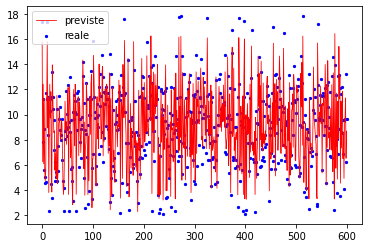

In [13]:
x_ax = range(len(Hum_X_test))
plt.scatter(x_ax, Hum_y_test, s=5, color='blue', label='reale')
plt.plot(x_ax, Hum_y_pred, lw=0.8, color='red', label='previste')
plt.legend()
plt.show()

# Multiple Linear Regression

simple multiple linear regression

In [14]:
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,16.081972,8.690398,7.360829,5.627949,10.859625,1
2,2,2,0,1,16.064222,8.711492,6.798350,5.695267,10.875454,1
3,2,2,0,1,15.726965,9.281037,6.458978,6.770428,11.357474,1
4,2,2,0,1,15.608629,9.414634,6.998203,6.968535,11.452773,1


In [0]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [16]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)

print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [-0.00511748  0.02444122 -0.18001676  0.13850251 -0.09397926 -0.14772692
  0.19721539  0.00644703  0.17109664]
Intercept: 
 0.2505723229354231
   
R2: 0.932568
MSE: 0.016839
MAE: 0.093422


lasso multiple linear regression

In [17]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.LassoCV(alphas=alfa, max_iter=10000)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
reg.fit(X_train,y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 0.000100
   
Coefficients: 
 [-0.00515052  0.02393461 -0.17909784  0.13627059 -0.09096021 -0.14035997
  0.19731803  0.0067289   0.16310744]
Intercept: 
 0.22530994826231665
   
R2: 0.932674
MSE: 0.016813
MAE: 0.093353


ridge multiple linear regression

In [18]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.RidgeCV(alphas=alfa, store_cv_values=True)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 0.100000
   
Coefficients: 
 [-0.00515604  0.02412434 -0.17884969  0.13661365 -0.09093142 -0.14027912
  0.19730859  0.00676466  0.16299885]
Intercept: 
 0.22446890461364677
   
R2: 0.932666
MSE: 0.016815
MAE: 0.093362


elastic net multiple linear regression

In [19]:
alfa = [1e-4,1e-3,1e-2,1e-1,1,1e2,1e3,1e4]
reg = linear_model.ElasticNetCV(alphas=alfa,max_iter=10000)
reg.fit(X_train, y_train)
print('Best value of alpha= %f' % reg.alpha_)
print('   ')

reg = linear_model.ElasticNet(alpha=0.0001, max_iter=10000)
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('   ')

y_pred = reg.predict(X_test)
print('R2: %.6f' % r2_score(y_test, y_pred))
print('MSE: %.6f' % mean_squared_error(y_test, y_pred))
print('MAE: %.6f' % mean_absolute_error(y_test, y_pred))

Best value of alpha= 0.000100
   
Coefficients: 
 [-0.00513679  0.02416598 -0.17947627  0.13725426 -0.09225038 -0.14350687
  0.19727319  0.0066107   0.1665187 ]
Intercept: 
 0.23606000576415087
   
R2: 0.932630
MSE: 0.016824
MAE: 0.093381
